# Deep Convolutional Auto-encoder
* Encoder:
    * 3 convolution+max-pooling layers
* Decoder:
    * 3 (de)convolution+up-sampling layers
Reconstruction of images plotted at the end of notebook.

In [1]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from random import randint
from helper_models.autoencoder import read_n_images, generate_img_from_folder, get_input_shape, get_num_examples, plot_history, get_images, bgr2rgb, plot_reconstruction

## Generate models
* Auto-encoder
* Encoder
* Decoder

**Set the layers for auto-encoder**

In [2]:
DATA_DIR = '../data'
in_shape = get_input_shape(DATA_DIR, 'training')



input_img = Input(shape=in_shape, name='input_layer')

x = Conv2D(16, (3, 3), activation='relu', padding='same', name='enc_conv1')(input_img)
x = MaxPooling2D((2, 2), padding='same', name='enc_max_pool1')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same', name='enc_conv2')(x)
x = MaxPooling2D((2, 2), padding='same', name='enc_max_pool2')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same', name='enc_conv3')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='enc_max_pool3')(x)

# at this point the representation is (25, 25, 8) - see model summaries

x = Conv2D(8, (3, 3), activation='relu', padding='same', name='dec_conv1')(encoded)
x = UpSampling2D((2, 2), name='dec_up_samp1')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same', name='dec_conv2')(x)
x = UpSampling2D((2, 2), name='dec_up_samp2')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same', name='dec_conv3')(x)
x = UpSampling2D((2, 2), name='dec_up_samp3')(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='output_layer')(x)

# Generate models
autoencoder = Model(input_img, decoded)

Instructions for updating:
Colocations handled automatically by placer.


**For encoder, simply select the input and output mapping**

In [3]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

**For decoder, redefine the input layer, select layers from auto-encoder**

In [4]:
# create a placeholder for an encoded (32-dimensional) input
encoding_dim = autoencoder.get_layer('enc_max_pool3').output_shape[1:]

input_enc = Input(shape=encoding_dim, name='enc_in')
deco = autoencoder.layers[-7](input_enc)
deco = autoencoder.layers[-6](deco)
deco = autoencoder.layers[-5](deco)
deco = autoencoder.layers[-4](deco)
deco = autoencoder.layers[-3](deco)
deco = autoencoder.layers[-2](deco)
deco = autoencoder.layers[-1](deco)

# create the decoder model
decoder = Model(input_enc, deco)

## Compile the model and get model summaries
Compiling only happens for `autoencoder` model.

In [5]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['mean_squared_error'])

In [6]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 200, 200, 3)       0         
_________________________________________________________________
enc_conv1 (Conv2D)           (None, 200, 200, 16)      448       
_________________________________________________________________
enc_max_pool1 (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
enc_conv2 (Conv2D)           (None, 100, 100, 8)       1160      
_________________________________________________________________
enc_max_pool2 (MaxPooling2D) (None, 50, 50, 8)         0         
_________________________________________________________________
enc_conv3 (Conv2D)           (None, 50, 50, 8)         584       
_________________________________________________________________
enc_max_pool3 (MaxPooling2D) (None, 25, 25, 8)         0         
Total para

In [7]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_in (InputLayer)          (None, 25, 25, 8)         0         
_________________________________________________________________
dec_conv1 (Conv2D)           (None, 25, 25, 8)         584       
_________________________________________________________________
dec_up_samp1 (UpSampling2D)  (None, 50, 50, 8)         0         
_________________________________________________________________
dec_conv2 (Conv2D)           (None, 50, 50, 8)         584       
_________________________________________________________________
dec_up_samp2 (UpSampling2D)  (None, 100, 100, 8)       0         
_________________________________________________________________
dec_conv3 (Conv2D)           (None, 100, 100, 16)      1168      
_________________________________________________________________
dec_up_samp3 (UpSampling2D)  (None, 200, 200, 16)      0         
__________

In [8]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 200, 200, 3)       0         
_________________________________________________________________
enc_conv1 (Conv2D)           (None, 200, 200, 16)      448       
_________________________________________________________________
enc_max_pool1 (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
enc_conv2 (Conv2D)           (None, 100, 100, 8)       1160      
_________________________________________________________________
enc_max_pool2 (MaxPooling2D) (None, 50, 50, 8)         0         
_________________________________________________________________
enc_conv3 (Conv2D)           (None, 50, 50, 8)         584       
_________________________________________________________________
enc_max_pool3 (MaxPooling2D) (None, 25, 25, 8)         0         
__________

## Training the auto-encoder
* Tune for batch size, number of epochs, etc.

In [9]:
BATCH_SIZE_TRAIN = 10
NUM_SAMPLES_TRAIN = get_num_examples(DATA_DIR, 'training')
STEPS_PER_EPOCH = ceil(NUM_SAMPLES_TRAIN/BATCH_SIZE_TRAIN)

BATCH_SIZE_VAL= 10
NUM_SAMPLES_VAL = get_num_examples(DATA_DIR, 'validation')
VALIDATION_STEPS=ceil(NUM_SAMPLES_VAL/BATCH_SIZE_VAL)

EPOCHS = 2

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = autoencoder.fit_generator(generate_img_from_folder(DATA_DIR, 'training', BATCH_SIZE_TRAIN), shuffle=True,
                                    validation_data=generate_img_from_folder(DATA_DIR, 'validation', BATCH_SIZE_VAL),
                                    steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS,
                                    epochs=EPOCHS)


Instructions for updating:
Use tf.cast instead.
Epoch 1/2
162/162 [==============================] - 154s 953ms/step - loss: 6.0903 - mean_squared_error: 0.0364 - val_loss: 5.6868 - val_mean_squared_error: 0.0195
Epoch 2/2
162/162 [==============================] - 156s 963ms/step - loss: 5.7049 - mean_squared_error: 0.0196 - val_loss: 5.6321 - val_mean_squared_error: 0.0174


## Accessment of model perfomance
* Visualize the training history
* Generate predictions for auto-encoder (reconstructed images)
* Visualize original and reconstructed images (for comparison)

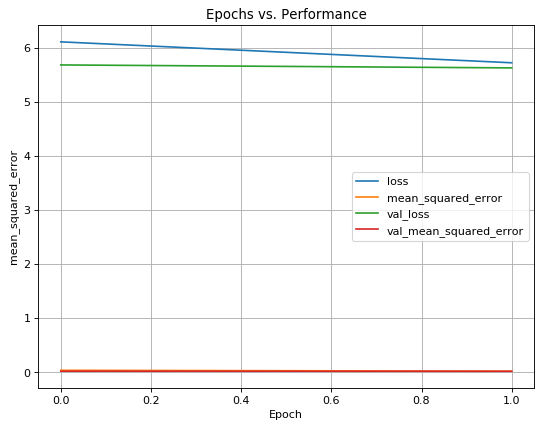

In [10]:
plot_history(history)

In [11]:
#Decoding images
BATCH_SIZE_TEST = 10
NUM_SAMPLES_TEST = get_num_examples(DATA_DIR, 'test')
STEPS_TEST = ceil(NUM_SAMPLES_TEST/BATCH_SIZE_TEST)

decoded_imgs = autoencoder.predict_generator(generate_img_from_folder(DATA_DIR, 'test', BATCH_SIZE_TEST),steps=STEPS_TEST)

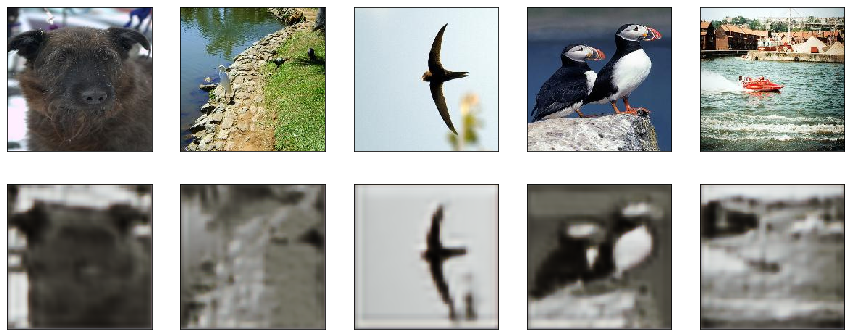

In [12]:
num_images = 5
idxs = [randint(0, NUM_SAMPLES_TEST) for i in range(num_images)]

plot_reconstruction(decoded_imgs, DATA_DIR, 'test', idxs)

**Encoded representation is by a `25x25x8` array so it is not implemented for now. One alternative is to display each layer as a grayscale image.**

## Sanity check:
See if  encoder-decoder are consisted with entire auto-encoder architecture

In [15]:
encoded_imgs = encoder.predict_generator(generate_img_from_folder(DATA_DIR, 'test', BATCH_SIZE_TEST),steps=STEPS_TEST)
decoded_imgs1 = decoder.predict(encoded_imgs)
if np.all(decoded_imgs1 == decoded_imgs):
    print("Output from decoded model is the same as the output from auto-encoder (everything looks good).")

Output from decoded model is the same as the output from auto-encoder (everything looks good).
